In [1]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
df = pd.read_csv("/kaggle/input/train.csv")
tdf = pd.read_csv("/kaggle/input/test.csv")
df

,file_id,text,source,category,class
0,3562022343909810991_63576812758,[NULL],Instagram,Safe,Safe
1,956326452811210,আমেরিকার ছাত্র আন্দোলন দমনের একটা দুর্লভ ফুটেজ,Facebook,Unsafe,Harmful
2,1621007965265006,গ্রামের সুন্দরী মেয়েদের সুন্দর ড্যান্স,Facebook,Unsafe,Adult
3,3382687520997377089_66846781731,[NULL],Instagram,Unsafe,Adult
4,507863908972262,ছেলেটার আজ আর বাড়ী যাওয়া হল না ময়মনসিংহ,Facebook,Safe,Safe
...,...,...,...,...,...
1531,1055274349411417,"শক্তি নাইরে বুড়ার গায়ে, তেল মাখতে হয় পায়ে। ওরে...",Facebook,Unsafe,Adult
1532,854716976272203,[NULL],Facebook,Safe,Safe
1533,3552382770196940051_63576812758,[NULL],Instagram,Safe,Safe
1534,6758856234238228,[NULL],Facebook,Unsafe,Adult


In [3]:
df = df[df['category']=='Unsafe']

In [4]:
tdf = tdf[tdf['category']=='Unsafe']

In [5]:
id2label = {
    "Adult": 0,
    "Harmful": 1,
    "Suicidal": 2
}

In [6]:
df['class'] = df['class'].map(id2label)
tdf['class'] = tdf['class'].map(id2label)

<ipython-input-6-0a23d245142c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'] = df['class'].map(id2label)


In [7]:
dir1 = "/kaggle/input/Audio_V1/Audio_V1"
dir2 = "/kaggle/input/Audio_V2/Audio_V2"
dir3 = "/kaggle/input/UNBER_IG/UNBER_IG/Audio_IG"

In [8]:
pip install noisereduce --quiet

Note: you may need to restart the kernel to use updated packages.


In [9]:
import os
import numpy as np
import pandas as pd
import librosa
import noisereduce as nr
import soundfile as sf

In [10]:
# def process_audio_for_vggish(file_path, target_window_duration=0.96, sample_rate=16000, 
#                              n_fft=400, hop_length=160, n_mels=64, expected_frames=96):
#     # Load and resample audio to 16kHz
#     audio, orig_sr = librosa.load(file_path, sr=None)
#     if orig_sr != sample_rate:
#         audio = resampy.resample(audio, orig_sr, sample_rate)

#     # Trim or pad to target duration (0.96 seconds for VGGish)
#     target_samples = int(target_window_duration * sample_rate)
#     if len(audio) > target_samples:
#         audio = audio[:target_samples]
#     else:
#         padding = target_samples - len(audio)
#         audio = np.pad(audio, (0, padding), mode='constant')

#     # Pre-emphasis (optional but common in audio preprocessing)
#     pre_emphasis = 0.96
#     audio = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])

#     # Compute mel spectrogram
#     mel_spec = librosa.feature.melspectrogram(
#         y=audio,
#         sr=sample_rate,
#         n_fft=n_fft,
#         hop_length=hop_length,
#         n_mels=n_mels,
#         power=2.0
#     )

#     # Convert to log scale (dB)
#     log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

#     # Transpose to shape (frames, bins)
#     log_mel_spec = log_mel_spec.T  # Shape becomes (num_frames, 64)

#     # Ensure the shape is exactly (96, 64)
#     if log_mel_spec.shape[0] < expected_frames:
#         pad_width = expected_frames - log_mel_spec.shape[0]
#         log_mel_spec = np.pad(log_mel_spec, ((0, pad_width), (0, 0)), mode='constant')
#     elif log_mel_spec.shape[0] > expected_frames:
#         log_mel_spec = log_mel_spec[:expected_frames, :]

#     return log_mel_spec  # Final shape: (96, 64)

In [11]:
def load_audio_mono_16k(path, target_sr=16000):
    waveform, sr = librosa.load(path, sr=None, mono=True)
    if sr != target_sr:
        waveform = librosa.resample(waveform, orig_sr=sr, target_sr=target_sr)
    waveform = waveform.astype(np.float32)
    return waveform[:16000]  # Trim/pad to 1 second

In [12]:
scaler = StandardScaler()

In [13]:
def extract(df1):
    X = []
    y = []
    for _, row in df1.iterrows():
        reel_id = row["file_id"]
        label = row["class"]  
    
        for dir in list([dir1, dir2, dir3]):
            audio_file = os.path.join(dir, f"{reel_id}.wav")
            if os.path.exists(audio_file): 
                processed_audio = load_audio_mono_16k(audio_file)      
                X.append(processed_audio)
                y.append(label)

    Xn = np.array(X, dtype=np.float32)
    yn = np.array(y)
    Xf = scaler.fit_transform(Xn)
    Xe = np.expand_dims(Xf, axis=-1)
    print(f'Final Shape: {Xe.shape}, {yn.shape}')
    return Xe, yn

In [14]:
X, y = extract(df)

Final Shape: (844, 16000, 1), (844,)


In [15]:
X_test, y_test = extract(tdf)

Final Shape: (212, 16000, 1), (212,)


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
import tensorflow as tf
import tensorflow_hub as hub

# Load YAMNet
yamnet_model_handle = "https://tfhub.dev/google/yamnet/1"
yamnet = hub.load(yamnet_model_handle)

In [18]:
def yamnet_feature_extractor(waveform, sample_rate=16000):
    # waveform: shape [n_samples] in float32, sampled at 16kHz
    # Returns embeddings and scores
    scores, embeddings, spectrogram = yamnet(waveform)
    return embeddings  # shape: [N, 1024]

In [19]:
def build_yamnet_transfer_model(input_length=16000, num_classes=1, dropout_rate=0.3):
    # Input: batch of 1D waveforms, shape (None, 16000)
    input_waveform = tf.keras.Input(shape=(input_length,), dtype=tf.float32)

    # Define a wrapper that works per sample
    def extract_embeddings_per_sample(waveform):
        _, embeddings, _ = yamnet(waveform)  # Each waveform -> [N, 1024]
        return embeddings  # shape: [N, 1024]

    # Map across batch
    embeddings = tf.keras.layers.Lambda(
        lambda x: tf.map_fn(
            extract_embeddings_per_sample,
            x,
            dtype=tf.float32,
            fn_output_signature=tf.TensorSpec(shape=(None, 1024), dtype=tf.float32)
        ),
        name="yamnet_embeddings"
    )(input_waveform)  # shape: (batch, N, 1024)

    # Average over time axis (N)
    x = tf.keras.layers.GlobalAveragePooling1D()(embeddings)  # shape: (batch, 1024)

    # Classifier head
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    output = tf.keras.layers.Dense(num_classes, activation='sigmoid' if num_classes == 1 else 'softmax')(x)

    return tf.keras.Model(inputs=input_waveform, outputs=output)

In [20]:
model = build_yamnet_transfer_model(input_length=16000, num_classes=3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 16000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ yamnet_embeddings (Lambda)           │ (None, 2, 1024)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,691 (260.51 KB)

 Trainable params: 66,691 (260.51 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

In [23]:
history = model.fit(
    X_train, y_train,  # training data
    epochs=50,  # number of epochs
    batch_size=16,  # batch size
    validation_data=(X_val, y_val),  # validation data
    callbacks=[early_stopping, lr_scheduler]  # early stopping
)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.3157 - loss: 1.1028 - val_accuracy: 0.5385 - val_loss: 0.9932 - learning_rate: 0.0010
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.5355 - loss: 0.9517 - val_accuracy: 0.5562 - val_loss: 0.9424 - learning_rate: 0.0010
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.5211 - loss: 0.9325 - val_accuracy: 0.5799 - val_loss: 0.9215 - learning_rate: 0.0010
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.5405 - loss: 0.8978 - val_accuracy: 0.5799 - val_loss: 0.9106 - learning_rate: 0.0010
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.6075 - loss: 0.8459 - val_accuracy: 0.6036 - val_loss: 0.8773 - learning_rate: 0.0010
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.5990 - loss: 0.8382 - val_accuracy: 0.6036 - val_loss: 0.8657 - learning_rate: 0.0010
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.5625 - loss: 0.8673 -

In [24]:
y_pred = model.predict(X_test)
#y_pred_classes = (y_pred >= 0.5).astype(int)
y_pred_classes = np.argmax(y_pred, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step


In [25]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.54      0.70      0.61        94
           1       0.35      0.14      0.20        63
           2       0.53      0.62      0.57        55

    accuracy                           0.51       212
   macro avg       0.47      0.49      0.46       212
weighted avg       0.48      0.51      0.48       212



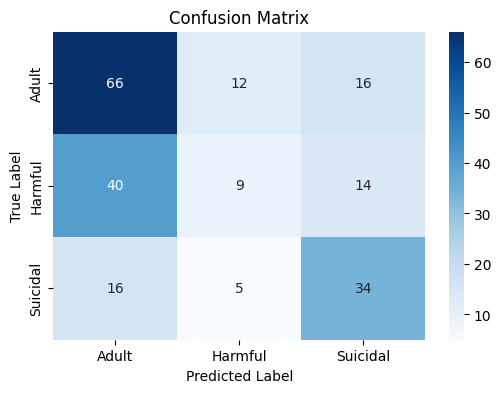

In [26]:
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=id2label.keys(), yticklabels=id2label.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()

In [27]:
# After training
model.save("yamnet_h2.keras")